In [ ]:
!pip install networkx matplotlib graphviz


In [ ]:
# STEP 1  → Source Code
source_code = """
def process_sales(sales):
    total = 0
    count = 0
    i = 0
    while i < len(sales):
        total += sales[i]
        count += 1
        i += 1

    if count == 0:
        return 0

    avg = total / count
    return avg


def classify_sales(avg):
    if avg > 10000:
        level = "High"
    elif avg > 5000:
        level = "Medium"
    else:
        level = "Low"
    return level


def main():
    sales_data = [12000, 8000, 15000, 4000, 6000]
    average = process_sales(sales_data)
    category = classify_sales(average)

    if category == "High":
        bonus = average * 0.10
    else:
        bonus = average * 0.05

    print("Average:", average)
    print("Category:", category)
    print("Bonus:", bonus)
"""


In [ ]:
# STEP 2  → Lexical Analysis (Tokens)
import tokenize
from io import BytesIO

tokens = []
for tok in tokenize.tokenize(BytesIO(source_code.encode()).readline):
    tokens.append((tokenize.tok_name[tok.type], tok.string))

print("STEP 2: TOKENS\n")
for t in tokens:
    print(t)

STEP 2: TOKENS

('ENCODING', 'utf-8')
('NL', '\n')
('NAME', 'def')
('NAME', 'process_sales')
('OP', '(')
('NAME', 'sales')
('OP', ')')
('OP', ':')
('NEWLINE', '\n')
('INDENT', '    ')
('NAME', 'total')
('OP', '=')
('NUMBER', '0')
('NEWLINE', '\n')
('NAME', 'count')
('OP', '=')
('NUMBER', '0')
('NEWLINE', '\n')
('NAME', 'i')
('OP', '=')
('NUMBER', '0')
('NEWLINE', '\n')
('NAME', 'while')
('NAME', 'i')
('OP', '<')
('NAME', 'len')
('OP', '(')
('NAME', 'sales')
('OP', ')')
('OP', ':')
('NEWLINE', '\n')
('INDENT', '        ')
('NAME', 'total')
('OP', '+=')
('NAME', 'sales')
('OP', '[')
('NAME', 'i')
('OP', ']')
('NEWLINE', '\n')
('NAME', 'count')
('OP', '+=')
('NUMBER', '1')
('NEWLINE', '\n')
('NAME', 'i')
('OP', '+=')
('NUMBER', '1')
('NEWLINE', '\n')
('NL', '\n')
('DEDENT', '')
('NAME', 'if')
('NAME', 'count')
('OP', '==')
('NUMBER', '0')
('OP', ':')
('NEWLINE', '\n')
('INDENT', '        ')
('NAME', 'return')
('NUMBER', '0')
('NEWLINE', '\n')
('NL', '\n')
('DEDENT', '')
('NAME', 'avg')
('

In [ ]:
#Total Number of Tokens
print("\nTotal no of tokens :", len(tokens))


Total no of tokens : 205


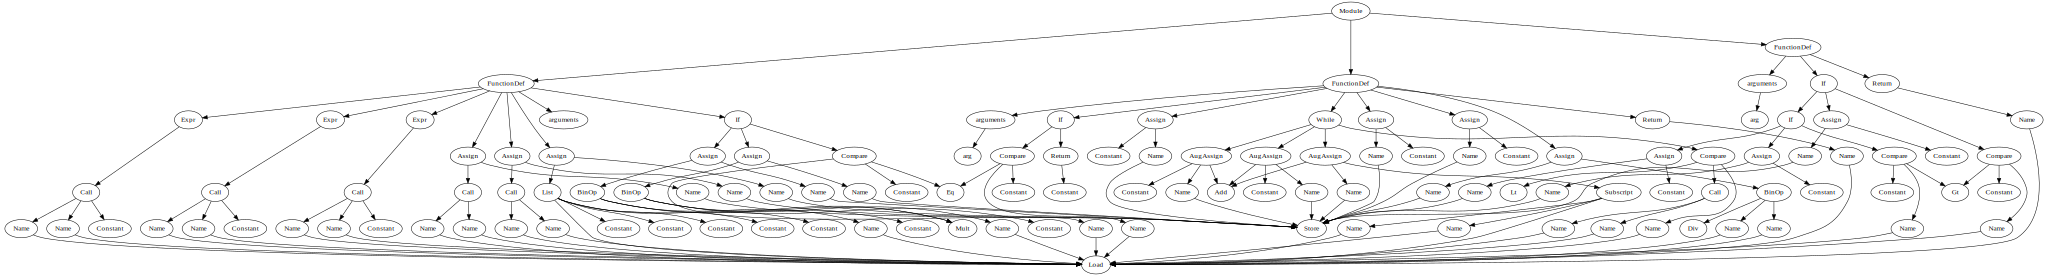

In [ ]:
# STEP 3  → Syntax Analysis (AST / Parse Tree)
import ast
import graphviz

tree = ast.parse(source_code)

def visualize_ast(node, graph, parent=None):
    node_id = str(id(node))
    label = type(node).__name__
    graph.node(node_id, label)

    if parent:
        graph.edge(parent, node_id)

    for child in ast.iter_child_nodes(node):
        visualize_ast(child, graph, node_id)

dot = graphviz.Digraph()
visualize_ast(tree, dot)
dot


In [ ]:
# STEP 4  → Semantic Analysis (USE / DEF)
class UseDefVisitor(ast.NodeVisitor):
    def __init__(self):
        self.ir = []

    def names(self, node):
        return {n.id for n in ast.walk(node) if isinstance(n, ast.Name)}

    def visit_Assign(self, node):
        defs = {t.id for t in node.targets if isinstance(t, ast.Name)}
        uses = self.names(node.value)
        self.ir.append({"DEF": defs, "USE": uses})
        self.generic_visit(node)

    def visit_AugAssign(self, node):
        defs = {node.target.id}
        uses = defs | self.names(node.value)
        self.ir.append({"DEF": defs, "USE": uses})
        self.generic_visit(node)

    def visit_If(self, node):
        self.ir.append({"DEF": set(), "USE": self.names(node.test)})
        self.generic_visit(node)

    def visit_While(self, node):
        self.ir.append({"DEF": set(), "USE": self.names(node.test)})
        self.generic_visit(node)

    def visit_Return(self, node):
        self.ir.append({"DEF": set(), "USE": self.names(node.value)})
        self.generic_visit(node)

visitor = UseDefVisitor()
visitor.visit(tree)
ir = visitor.ir

print("\nSTEP 4: USE / DEF\n")
for i, ins in enumerate(ir):
    print(i, ins)



STEP 4: USE / DEF

0 {'DEF': {'total'}, 'USE': set()}
1 {'DEF': {'count'}, 'USE': set()}
2 {'DEF': {'i'}, 'USE': set()}
3 {'DEF': set(), 'USE': {'len', 'i', 'sales'}}
4 {'DEF': {'total'}, 'USE': {'sales', 'i', 'total'}}
5 {'DEF': {'count'}, 'USE': {'count'}}
6 {'DEF': {'i'}, 'USE': {'i'}}
7 {'DEF': set(), 'USE': {'count'}}
8 {'DEF': set(), 'USE': set()}
9 {'DEF': {'avg'}, 'USE': {'count', 'total'}}
10 {'DEF': set(), 'USE': {'avg'}}
11 {'DEF': set(), 'USE': {'avg'}}
12 {'DEF': {'level'}, 'USE': set()}
13 {'DEF': set(), 'USE': {'avg'}}
14 {'DEF': {'level'}, 'USE': set()}
15 {'DEF': {'level'}, 'USE': set()}
16 {'DEF': set(), 'USE': {'level'}}
17 {'DEF': {'sales_data'}, 'USE': set()}
18 {'DEF': {'average'}, 'USE': {'sales_data', 'process_sales'}}
19 {'DEF': {'category'}, 'USE': {'classify_sales', 'average'}}
20 {'DEF': set(), 'USE': {'category'}}
21 {'DEF': {'bonus'}, 'USE': {'average'}}
22 {'DEF': {'bonus'}, 'USE': {'average'}}


In [ ]:
# STEP 5  → Live Variable Analysis
IN = [set() for _ in ir]
OUT = [set() for _ in ir]

changed = True
while changed:
    changed = False
    for i in reversed(range(len(ir))):
        old = IN[i].copy()
        OUT[i] = IN[i+1] if i+1 < len(ir) else set()
        IN[i] = ir[i]["USE"] | (OUT[i] - ir[i]["DEF"])
        if old != IN[i]:
            changed = True


In [ ]:
from collections import defaultdict

graph = defaultdict(set)
for live in OUT:
    live = list(live)
    for i in range(len(live)):
        for j in range(i+1, len(live)):
            graph[live[i]].add(live[j])
            graph[live[j]].add(live[i])


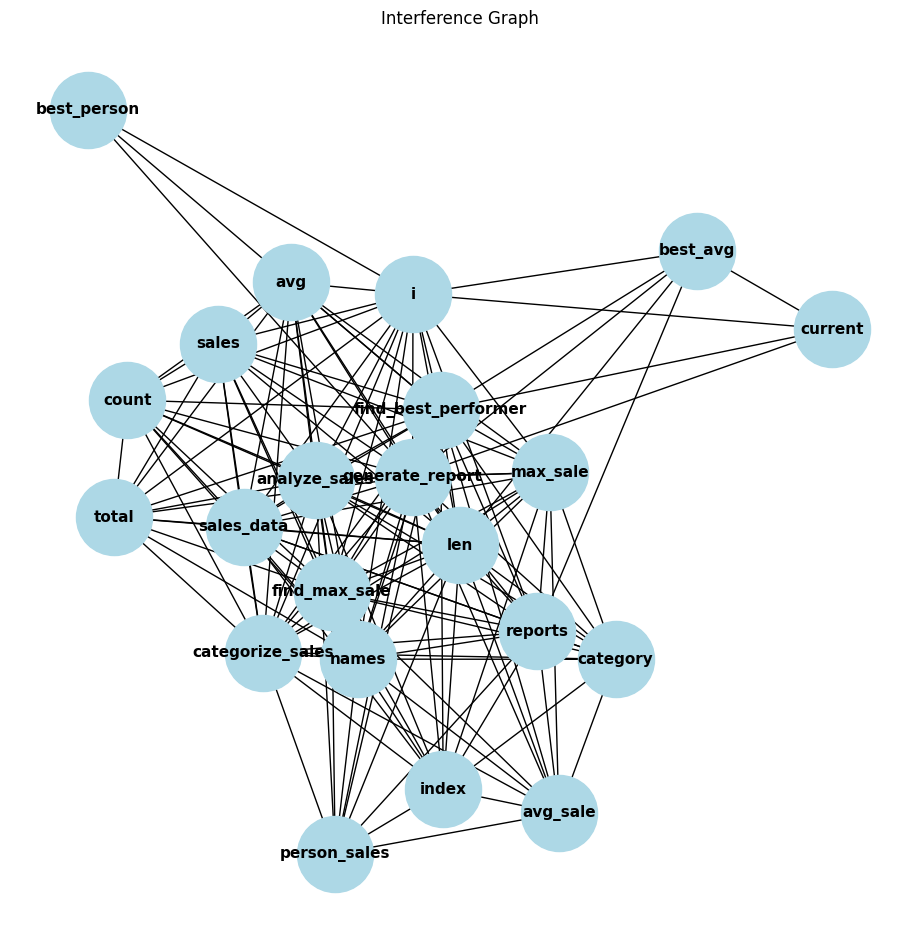

In [ ]:
# STEP 6 -> Interference Graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for u in interference_graph:
    for v in interference_graph[u]:
        G.add_edge(u, v)

plt.figure(figsize=(9, 9))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color="lightblue",
        node_size=3000,
        font_size=11,
        font_weight="bold")
plt.title("Interference Graph")
plt.show()


In [ ]:
# STEP 7  → Graph Coloring (≤ 50 Registers)
MAX_REGISTERS = 50
REGISTERS = [f"R{i+1}" for i in range(MAX_REGISTERS)]

allocation = {}
spilled = set()

nodes = sorted(interference_graph,
               key=lambda x: len(interference_graph[x]),
               reverse=True)

for node in nodes:
    used = {allocation[n] for n in interference_graph[node] if n in allocation}
    for r in REGISTERS:
        if r not in used:
            allocation[node] = r
            break
    else:
        spilled.add(node)


In [ ]:
# No. of Registers used
used_registers = set(allocation.values())

print("Total Registers Available :", MAX_REGISTERS)
print("Registers Actually Used   :", len(used_registers))
print("Registers Used            :", sorted(used_registers))


Total Registers Available : 50
Registers Actually Used   : 13
Registers Used            : ['R1', 'R10', 'R11', 'R12', 'R13', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9']


In [ ]:
if spilled:
    print("\nSpilled Variables (Stored in Memory):")
    for v in spilled:
        print(v)
else:
    print("\nNo variables spilled")



No variables spilled


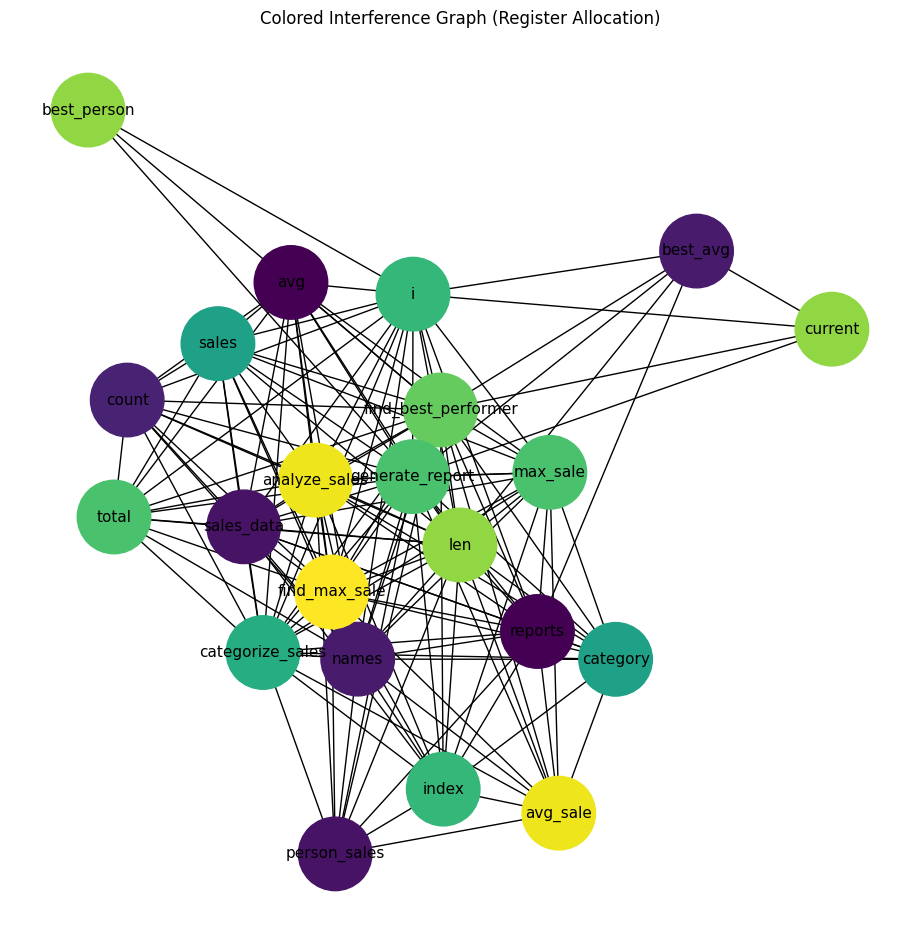

In [ ]:
# STEP 8  → Colored Graph Visualization
G = nx.Graph()
for u in interference_graph:
    for v in interference_graph[u]:
        G.add_edge(u, v)

color_map = []
for node in G.nodes():
    if node in allocation:
        color_map.append(hash(allocation[node]) % 50)
    else:
        color_map.append("black")

plt.figure(figsize=(9, 9))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color=color_map,
        node_size=2800,
        font_size=11)
plt.title("Colored Interference Graph (Register Allocation)")
plt.show()
